In [5]:
# makes an interactive graph showing npm package dependency relationships
# lets user input a rank range (ex. 1–500) to visualize part of dataset
# clicking a node highlights connections and shows global dependents + dependencies
# exports interactive html file you can open in browser

import pandas as pd
import networkx as nx
from pyvis.network import Network
from ast import literal_eval

# load csv with top 5000 npm packages
df = pd.read_csv("top_5000_npm_packages.csv")

# safely parse dependency lists
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)

# combine deps + devDeps into single list
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]

# build global dependency maps (for full dataset)
dependents_map = {}
dependencies_map = {}

for _, row in df.iterrows():
    pkg = row["package_name"]
    deps = row["all_dependencies"]
    dependencies_map[pkg] = len(deps)
    for dep in deps:
        dependents_map.setdefault(dep, set()).add(pkg)

global_dependents_count = {pkg: len(dependents_map.get(pkg, [])) for pkg in df["package_name"]}
global_dependencies_count = {pkg: dependencies_map.get(pkg, 0) for pkg in df["package_name"]}

# load ranked dependents list
dependents = pd.read_csv("direct_dependents_top5000.csv")

# ask user for rank range to visualize
try:
    lower = int(input("enter lower rank (ex. 1): "))
    upper = int(input("enter upper rank (ex. 500): "))
    if lower < 1: lower = 1
    if upper < lower:
        print("⚠️ upper bound must be higher — using +100 instead")
        upper = lower + 100
except ValueError:
    print("⚠️ invalid input, defaulting to 1–500")
    lower, upper = 1, 500

# filter dataset to selected range
sub_rank = dependents.iloc[lower-1:upper]
top_packages = sub_rank["package_name"].tolist()
sub_df = df[df["package_name"].isin(top_packages)]

# build dependency graph
G = nx.DiGraph()
for _, row in sub_df.iterrows():
    pkg = row["package_name"]
    for dep in row["all_dependencies"]:
        if dep in top_packages:
            G.add_edge(pkg, dep)

# trim edges for performance if needed
if G.number_of_edges() > 10000:
    print(f"⚠️ graph has {G.number_of_edges()} edges — trimming to top 10k for speed.")
    G = nx.DiGraph(list(G.edges())[:10000])

# create interactive network
net = Network(
    height="850px",
    width="100%",
    bgcolor="#f8fafc",
    font_color="#111",
    directed=True,
    notebook=False,
)

# graph layout + visual settings
net.set_options(f"""
{{
  "interaction": {{
    "hover": true,
    "navigationButtons": true
  }},
  "nodes": {{
    "shape": "dot",
    "scaling": {{
      "label": {{ "enabled": true }}
    }}
  }},
  "edges": {{
    "color": {{
      "color": "#94a3b8",
      "highlight": "#ef4444",
      "hover": "#ef4444"
    }},
    "width": 1.2,
    "selectionWidth": 3,
    "smooth": {{ "type": "dynamic" }}
  }},
  "physics": {{
    "enabled": true,
    "barnesHut": {{
      "gravitationalConstant": -20000,
      "centralGravity": 0.3,
      "springLength": 300,
      "springConstant": 0.02,
      "damping": 0.9
    }}
  }}
}}
""")

# add nodes and edges
net.from_nx(G)

# style nodes and attach global stats
degree_dict = dict(G.out_degree())
for node in net.nodes:
    pkg = node["id"]
    local_degree = degree_dict.get(pkg, 1)
    global_deps = global_dependencies_count.get(pkg, 0)
    global_dependents = global_dependents_count.get(pkg, 0)

    node["size"] = local_degree * 1.5 + 8
    node["title"] = f"{pkg} — direct dependents (global): {global_dependents}"
    node["color"] = {
        "background": "#60a5fa",
        "border": "#1d4ed8",
        "highlight": {"background": "#f43f5e", "border": "#b91c1c"}
    }
    node["font"] = {"color": "#111", "size": 18}
    node["globalDependents"] = global_dependents
    node["globalDependencies"] = global_deps

for edge in net.edges:
    edge["arrows"] = "to"

# overlay with title + info box
html_overlay = f"""
<script type="text/javascript">
function addClickEvent(network) {{
    // floating title
    const header = document.createElement('div');
    header.style.position = 'absolute';
    header.style.top = '10px';
    header.style.left = '50%';
    header.style.transform = 'translateX(-50%)';
    header.style.textAlign = 'center';
    header.style.backgroundColor = 'rgba(255,255,255,0.9)';
    header.style.padding = '8px 18px';
    header.style.borderRadius = '10px';
    header.style.boxShadow = '0 2px 8px rgba(0,0,0,0.1)';
    header.style.fontFamily = 'Inter, sans-serif';
    header.style.fontSize = '20px';
    header.style.fontWeight = '600';
    header.style.zIndex = '1000';
    header.textContent = 'npm packages ranked {lower}–{upper} by direct dependents';
    document.body.appendChild(header);

    // info box
    const infoBox = document.createElement('div');
    infoBox.id = 'infoBox';
    infoBox.style.position = 'absolute';
    infoBox.style.bottom = '20px';
    infoBox.style.left = '20px';
    infoBox.style.backgroundColor = 'white';
    infoBox.style.border = '1px solid #ddd';
    infoBox.style.padding = '12px 16px';
    infoBox.style.borderRadius = '10px';
    infoBox.style.boxShadow = '0 2px 6px rgba(0,0,0,0.15)';
    infoBox.style.fontFamily = 'Inter, sans-serif';
    infoBox.style.fontSize = '16px';
    infoBox.style.zIndex = '999';
    infoBox.innerHTML = '<b>click a node</b> to see its details.';
    document.body.appendChild(infoBox);

    // stop physics after stabilization
    network.once("stabilizationIterationsDone", function () {{
        network.setOptions({{ physics: false }});
    }});

    // click event to show global stats
    network.on('click', function(params) {{
        if (params.nodes.length > 0) {{
            const nodeId = params.nodes[0];
            const nodeData = network.body.data.nodes.get(nodeId);
            const globalDependents = nodeData.globalDependents || 0;
            const globalDependencies = nodeData.globalDependencies || 0;

            document.getElementById('infoBox').innerHTML =
              '<b>selected package:</b> ' + nodeId +
              '<br><b>direct dependents (global):</b> ' + globalDependents +
              '<br><b>dependencies (global):</b> ' + globalDependencies;
        }}
    }});
}}

window.addEventListener("load", () => {{
    if (window.network) addClickEvent(window.network);
}});
</script>
"""

# export to html
net.write_html("dependents_network.html", local=False)
with open("dependents_network.html", "a") as f:
    f.write(html_overlay)

print("open 'interactive_dependents_graph.html' from your file browser")


open 'interactive_dependents_graph.html' from your file browser


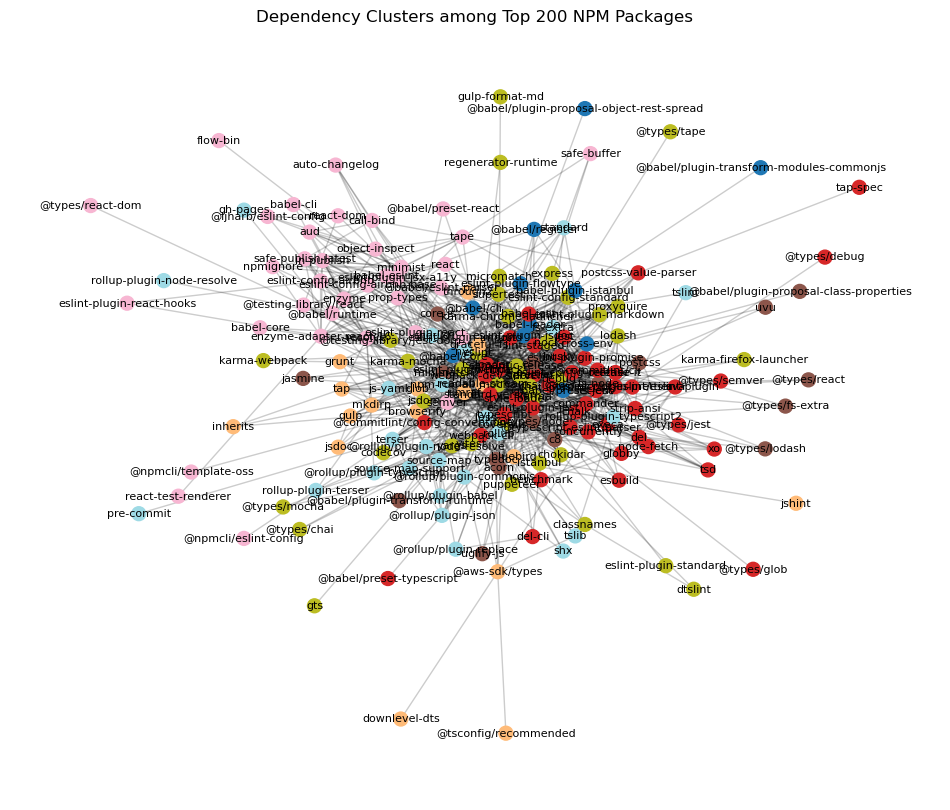

In [9]:
# finds natural "clusters" of interdependent npm packages
# uses community detection to color-code packages that depend on each other
# visualizes top 200 packages in a simple network layout

!pip install python-louvain --quiet
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # pip install python-louvain
from ast import literal_eval

# load top 5000 npm dataset
df = pd.read_csv("top_5000_npm_packages.csv")

# safely parse dependencies
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]

# filter top packages for visibility
top_packages = pd.read_csv("direct_dependents_top5000.csv").head(200)["package_name"].tolist()
sub_df = df[df["package_name"].isin(top_packages)]

# build undirected graph to detect communities
G = nx.Graph()
for _, row in sub_df.iterrows():
    pkg = row["package_name"]
    for dep in row["all_dependencies"]:
        if dep in top_packages:
            G.add_edge(pkg, dep)

# compute community clusters
partition = community_louvain.best_partition(G)

# assign colors based on cluster id
colors = [partition[node] for node in G.nodes()]

# visualize
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.25)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=colors, cmap="tab20")
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Dependency Clusters among Top 200 NPM Packages")
plt.axis("off")
plt.show()

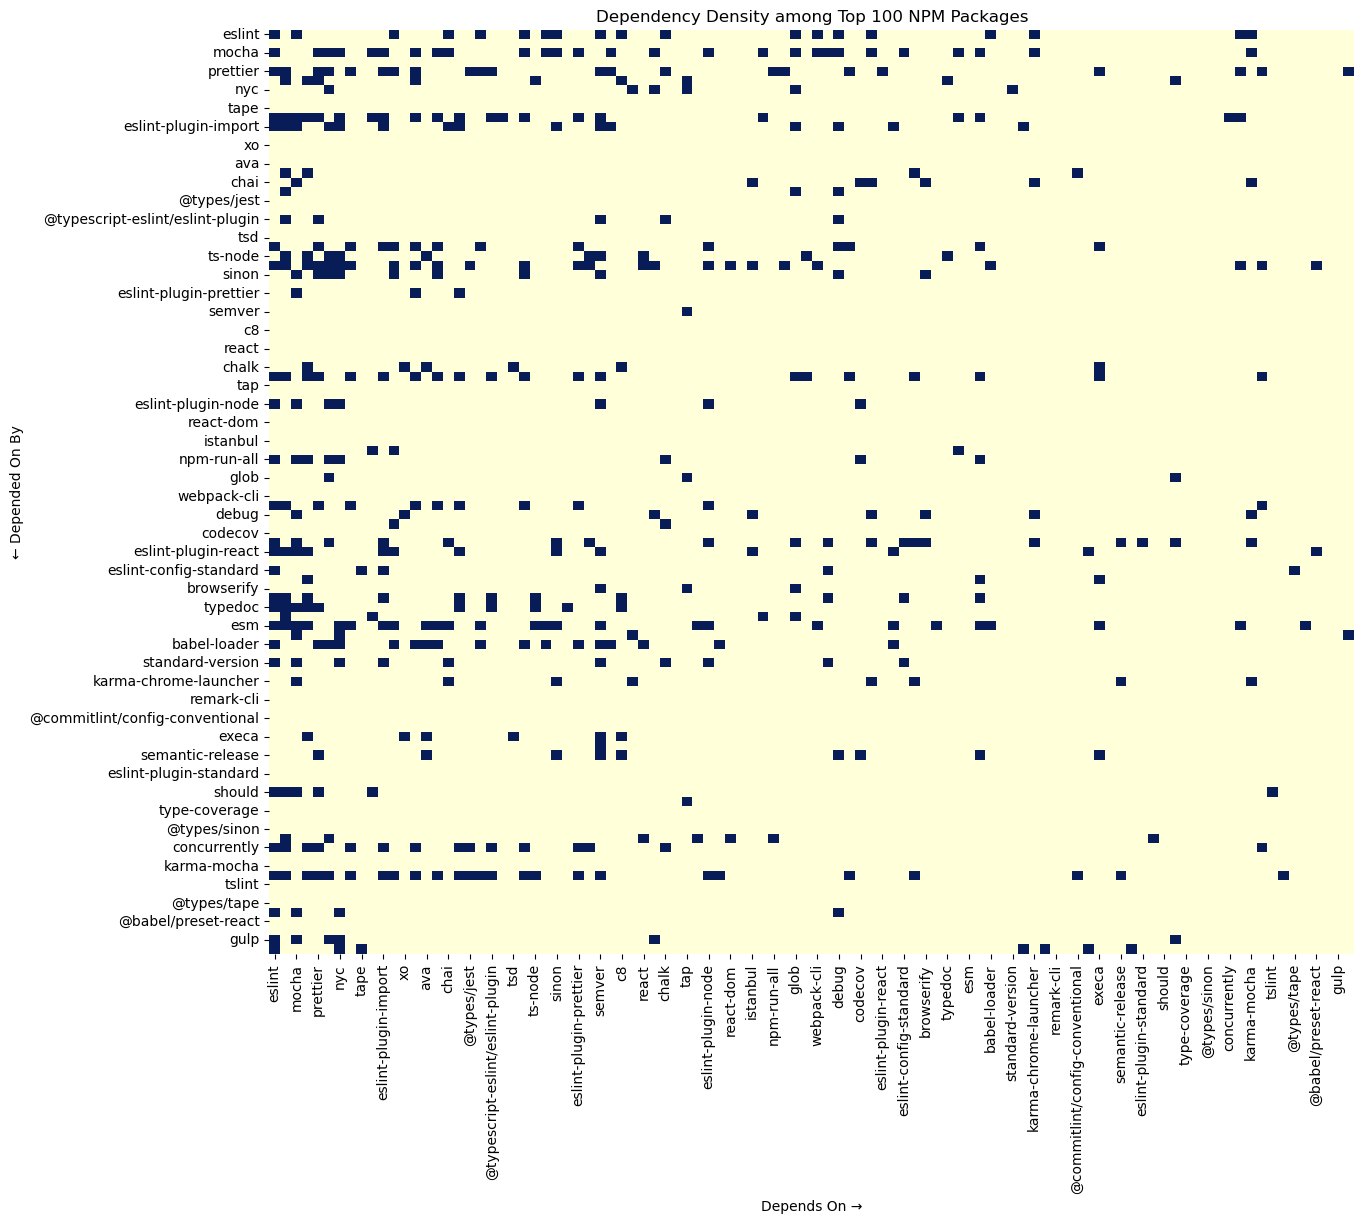

In [7]:
# builds a heatmap showing dependency density among top 100 packages
# darker cells = stronger dependency link between two packages
# shows how tightly the ecosystem connects internally

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# load data
df = pd.read_csv("top_5000_npm_packages.csv")

# parse dependency lists
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]

# focus on top 100 packages
top = pd.read_csv("direct_dependents_top5000.csv").head(100)["package_name"].tolist()
sub_df = df[df["package_name"].isin(top)]

# build adjacency matrix
matrix = pd.DataFrame(0, index=top, columns=top)
for _, row in sub_df.iterrows():
    pkg = row["package_name"]
    for dep in row["all_dependencies"]:
        if dep in top:
            matrix.loc[pkg, dep] = 1

# plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(matrix, cmap="YlGnBu", cbar=False)
plt.title("Dependency Density among Top 100 NPM Packages")
plt.xlabel("Depends On →")
plt.ylabel("← Depended On By")
plt.show()

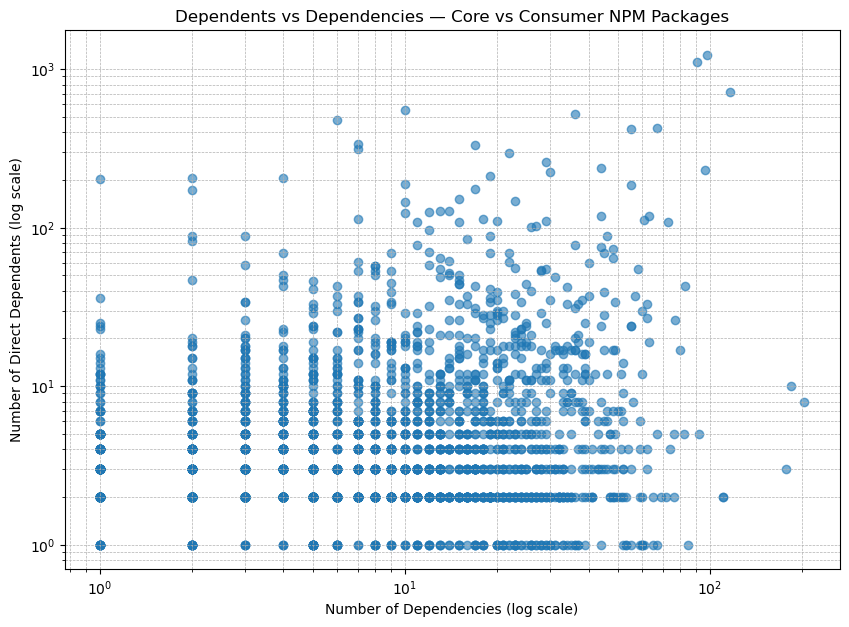

In [8]:
# compares how many packages depend on each one vs how many dependencies they have
# helps identify "core" vs "consumer" npm packages
# core = many dependents, few dependencies / consumer = opposite

import pandas as pd
import matplotlib.pyplot as plt

# load ranked dependents list and dependency counts
dependents = pd.read_csv("direct_dependents_top5000.csv")
df = pd.read_csv("top_5000_npm_packages.csv")

# count number of dependencies per package
from ast import literal_eval
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]
df["num_dependencies"] = df["all_dependencies"].apply(len)

# merge dependents + dependencies info
merged = pd.merge(dependents, df[["package_name", "num_dependencies"]], on="package_name", how="inner")

# scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(merged["num_dependencies"], merged["num_direct_dependents"], alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Dependencies (log scale)")
plt.ylabel("Number of Direct Dependents (log scale)")
plt.title("Dependents vs Dependencies — Core vs Consumer NPM Packages")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

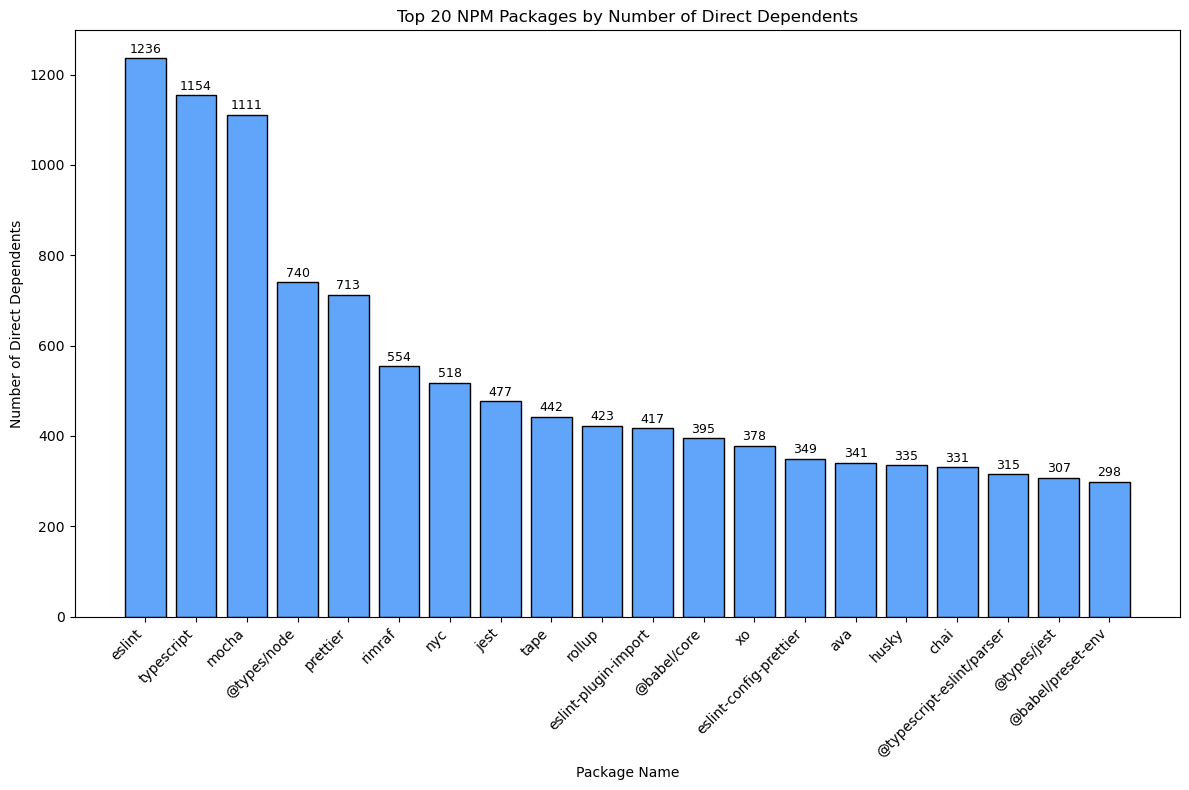

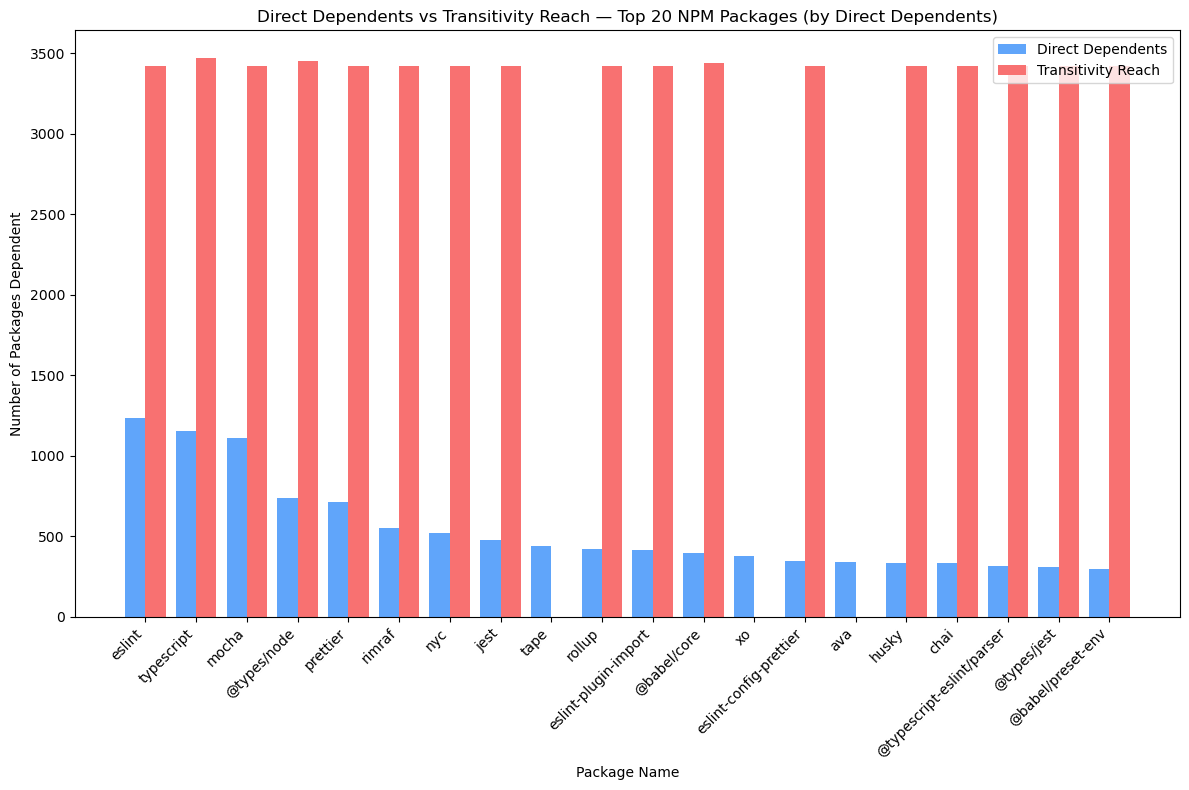

In [18]:
# shows which npm packages have the largest dependency influence
# compares direct dependents vs total transitivity reach
# focuses on the top 20 packages with the most direct dependents

import pandas as pd
import matplotlib.pyplot as plt

# load both datasets
dependents = pd.read_csv("direct_dependents_top5000.csv")
reach = pd.read_csv("transitivity_reach_top5000.csv")

# ------------------------------------------------------------
# part 1: clean visualization of top 20 by direct dependents
# ------------------------------------------------------------

# sort by direct dependents descending and take top 20
dependents_sorted = dependents.sort_values("num_direct_dependents", ascending=False).head(20)

# plot top 20 by number of direct dependents
plt.figure(figsize=(12, 8))
plt.bar(dependents_sorted["package_name"], dependents_sorted["num_direct_dependents"],
        color="#60a5fa", edgecolor="black")

# add labels and title
plt.xticks(rotation=45, ha="right")
plt.xlabel("Package Name")
plt.ylabel("Number of Direct Dependents")
plt.title("Top 20 NPM Packages by Number of Direct Dependents")

# add value labels above bars
for i, v in enumerate(dependents_sorted["num_direct_dependents"]):
    plt.text(i, v + (max(dependents_sorted["num_direct_dependents"]) * 0.01),
             f"{v}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# part 2: bar comparison chart (direct dependents vs transitivity reach)
# ------------------------------------------------------------

# merge datasets
merged = pd.merge(dependents_sorted, reach, on="package_name", how="left")

# create bar chart comparing direct vs total reach
plt.figure(figsize=(12, 8))

# x positions for bar groups
x = range(len(merged))
width = 0.4  # width of each bar

# plot bars for both metrics
plt.bar([i - width/2 for i in x], merged["num_direct_dependents"], width=width,
        label="Direct Dependents", color="#60a5fa")
plt.bar([i + width/2 for i in x], merged["transitive_reach"], width=width,
        label="Transitivity Reach", color="#f87171")

# add labels and title
plt.xticks(x, merged["package_name"], rotation=45, ha="right")
plt.xlabel("Package Name")
plt.ylabel("Number of Packages Dependent")
plt.title("Direct Dependents vs Transitivity Reach — Top 20 NPM Packages (by Direct Dependents)")
plt.legend()

plt.tight_layout()
plt.show()